In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class DeskDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.df = pd.read_csv("data/annotations.csv", names=["class", "xmin", "ymin", "xdist", "ydist", "image", "imgx", "imgy"])
        unique_classes = list(self.df['class'].unique())
        self.class_names = {unique_classes[i]: np.arange(1, 1 + len(unique_classes))[i] for i in range(len(unique_classes))}
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "data", "training_data"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "data", "training_data", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")

        features = self.df[self.df['image'] == self.imgs[idx]] 
        boxes = []
        labels = []
        for index, row in features.iterrows():
            xmin = row['xmin']
            xmax = row['xmin'] + row['xdist']
            ymin = row['ymin']
            ymax = row['ymin'] + row['ydist']
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.class_names[row['class']])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        num_objs = len(boxes)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

ds = DeskDataset(".")

In [2]:
print(len(ds.imgs))
print(len(ds.class_names))

48
4


In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
      
def get_object_detection_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [12]:
from helper.engine import train_one_epoch, evaluate
import helper.utils
import helper.transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [13]:
# use our dataset and defined transformations
dataset = DeskDataset('.', get_transform(train=True))
dataset_test = DeskDataset('.', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-44])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-4:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 1 + len(ds.class_names)

# get the model using our helper function
model = get_object_detection_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [14]:
# let's train it for 10 epochs
num_epochs = 20

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    # evaluate(model, data_loader_test, device=device)

Epoch: [0]  [0/2]  eta: 0:00:01  lr: 0.005000  loss: 0.4968 (0.4968)  loss_classifier: 0.3000 (0.3000)  loss_box_reg: 0.1733 (0.1733)  loss_objectness: 0.0065 (0.0065)  loss_rpn_box_reg: 0.0170 (0.0170)  time: 0.8917  data: 0.2418  max mem: 2843
Epoch: [0]  [1/2]  eta: 0:00:00  lr: 0.005000  loss: 0.4968 (0.6706)  loss_classifier: 0.3000 (0.3949)  loss_box_reg: 0.1733 (0.2511)  loss_objectness: 0.0031 (0.0048)  loss_rpn_box_reg: 0.0170 (0.0199)  time: 0.7081  data: 0.1245  max mem: 2843
Epoch: [0] Total time: 0:00:01 (0.7260 s / it)
Epoch: [1]  [0/2]  eta: 0:00:01  lr: 0.000500  loss: 0.5810 (0.5810)  loss_classifier: 0.2893 (0.2893)  loss_box_reg: 0.2557 (0.2557)  loss_objectness: 0.0165 (0.0165)  loss_rpn_box_reg: 0.0196 (0.0196)  time: 0.7282  data: 0.1532  max mem: 2843
Epoch: [1]  [1/2]  eta: 0:00:00  lr: 0.000500  loss: 0.5662 (0.5736)  loss_classifier: 0.2893 (0.2949)  loss_box_reg: 0.2466 (0.2512)  loss_objectness: 0.0024 (0.0094)  loss_rpn_box_reg: 0.0167 (0.0181)  time: 0.629

Epoch: [15]  [1/2]  eta: 0:00:00  lr: 0.000000  loss: 0.5291 (0.6003)  loss_classifier: 0.2922 (0.3111)  loss_box_reg: 0.2225 (0.2617)  loss_objectness: 0.0029 (0.0120)  loss_rpn_box_reg: 0.0115 (0.0155)  time: 0.7784  data: 0.2218  max mem: 2843
Epoch: [15] Total time: 0:00:01 (0.7959 s / it)
Epoch: [16]  [0/2]  eta: 0:00:01  lr: 0.000000  loss: 0.6093 (0.6093)  loss_classifier: 0.3014 (0.3014)  loss_box_reg: 0.2670 (0.2670)  loss_objectness: 0.0251 (0.0251)  loss_rpn_box_reg: 0.0158 (0.0158)  time: 0.7158  data: 0.1308  max mem: 2843
Epoch: [16]  [1/2]  eta: 0:00:00  lr: 0.000000  loss: 0.6093 (0.6121)  loss_classifier: 0.3014 (0.3102)  loss_box_reg: 0.2568 (0.2619)  loss_objectness: 0.0234 (0.0243)  loss_rpn_box_reg: 0.0157 (0.0157)  time: 0.6258  data: 0.0681  max mem: 2843
Epoch: [16] Total time: 0:00:01 (0.6426 s / it)
Epoch: [17]  [0/2]  eta: 0:00:01  lr: 0.000000  loss: 0.4757 (0.4757)  loss_classifier: 0.2534 (0.2534)  loss_box_reg: 0.1929 (0.1929)  loss_objectness: 0.0113 (0.

In [15]:
torch.save(model.state_dict(), "data/object_detection_model.pt")

In [16]:
from torchvision import transforms
# pick one image from the test set
# img, _ = dataset[1]
t = Image.open("data/desk-left-right.png").convert("RGB")
img = transforms.ToTensor()(t).squeeze()

# put the model in evaluation mode
model.load_state_dict(torch.load("data/object_detection_model.pt"))
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [17]:
prediction

[{'boxes': tensor([[ 849.7225,  884.0766, 1700.2302, 1306.6902],
          [1037.2544,  955.6371, 1562.9202, 1290.5217],
          [1621.9438,  831.9220, 2001.4763, 1621.6689],
          [ 246.1654,  853.8694,  929.6082, 1680.6531],
          [   4.4590, 1021.1376,  860.9623, 1920.0001],
          [ 976.9604,  973.6541, 1644.6288, 1546.9867],
          [ 239.8849,  826.7564,  932.9225, 1681.7157],
          [1691.8495, 1026.5521, 1992.1021, 1470.0713],
          [1060.4287, 1366.5980, 1583.5498, 1571.6449],
          [ 603.2356, 1044.6577, 1750.3398, 1880.3400],
          [1052.2327,  915.8132, 1887.9104, 1909.0411],
          [ 806.7005, 1260.2356, 1785.1099, 1672.7268],
          [1381.4487, 1006.1229, 2046.0692, 1694.2040],
          [ 544.1879, 1140.6580, 1550.0555, 1650.5636],
          [1009.3177,  840.2646, 1674.4380, 1370.8468],
          [ 999.9576,  834.3932, 1674.5404, 1362.1278],
          [ 617.9045, 1042.3036, 1739.5040, 1894.0577],
          [ 714.1873, 1059.2761, 1188.6

<Figure size 432x288 with 0 Axes>

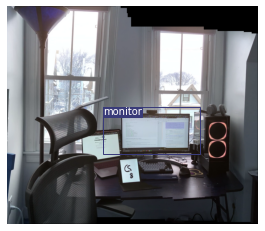

In [19]:
import matplotlib
import matplotlib.pyplot as plt

image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
plt.figure()
figure, ax = plt.subplots(1)
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

for box, score, class_name in zip(prediction[0]['boxes'], prediction[0]['scores'], prediction[0]['labels']):
    if score > 0.29:
        x, y = box[0], box[1]
        len_x, len_y = box[2] - box[0], box[3] - box[1]
        rect = matplotlib.patches.Rectangle((x, y), len_x, len_y, edgecolor=colors[0], facecolor="none")
        ax.add_patch(rect)
        plt.text(x, y, s="monitor", color='white', verticalalignment='top',
                    bbox={'color': colors[0], 'pad': 0})

ax.imshow(image)
plt.axis('off')
plt.savefig("data/desk-left-right-detected")
plt.show()

In [ ]:
# APPENDIX

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
plt.figure()
figure, ax = plt.subplots(1)
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]
labels = {1: 'monitor', 2: 'keyboard', 3: 'desktop', 4: 'plant'}

for idx, (box, score, class_name) in enumerate(zip(prediction[0]['boxes'], prediction[0]['scores'], prediction[0]['labels'])):
    if idx in [0, 6, 15]:
        x, y = box[0], box[1]
        len_x, len_y = box[2] - box[0], box[3] - box[1]
        rect = matplotlib.patches.Rectangle((x, y), len_x, len_y, edgecolor=colors[int(class_name.cpu().numpy())], facecolor="none")
        ax.add_patch(rect)
        plt.text(x, y, s=labels[int(class_name.cpu().numpy())], color='white', verticalalignment='top',
                    bbox={'color': colors[int(class_name.cpu().numpy())], 'pad': 0})

print(ds.class_names)
ax.imshow(image)
plt.axis('off')
plt.savefig("training_result")

In [ ]:
print(ds.class_names)

[{'boxes': tensor([[0.0000e+00, 4.0036e+02, 1.2729e+03, 1.1794e+03],
        [8.1681e+02, 1.0082e+03, 1.7607e+03, 1.5881e+03],
        [8.4376e+02, 8.9454e+02, 1.4104e+03, 1.6798e+03],
        [3.4775e+02, 5.3363e+02, 1.1411e+03, 1.2992e+03],
        [2.1702e+02, 2.0909e+02, 1.1067e+03, 1.5158e+03],
        [9.8893e+02, 9.5005e+02, 1.5821e+03, 1.7774e+03],
        [0.0000e+00, 1.6689e+00, 8.7493e+02, 4.7119e+02],
        [0.0000e+00, 6.1617e+02, 8.8175e+02, 1.1650e+03],
        [1.5182e+02, 4.2599e+02, 8.6204e+02, 1.0211e+03],
        [1.6140e+03, 8.4490e+02, 1.9490e+03, 1.2913e+03],
        [1.0282e+03, 0.0000e+00, 1.8428e+03, 1.3173e+03],
        [8.5937e+02, 7.4975e+02, 1.7415e+03, 1.9133e+03],
        [1.6104e+02, 5.4143e+02, 9.6917e+02, 1.9398e+03],
        [2.6079e+02, 4.2210e+02, 1.0594e+03, 1.1483e+03],
        [9.7331e+02, 9.5633e+02, 1.6289e+03, 1.5320e+03],
        [1.8426e+02, 5.1531e+02, 7.6813e+02, 1.4638e+03],
        [7.1406e+02, 9.1327e+02, 1.6656e+03, 1.3813e+03],
   

<Figure size 432x288 with 0 Axes>

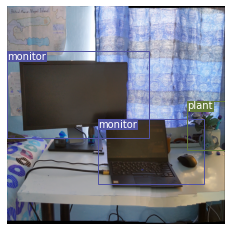

In [27]:
import matplotlib
import matplotlib.pyplot as plt

from torchvision import transforms
t = Image.open("data/desk.png").convert("RGB")
img = transforms.ToTensor()(t).squeeze()

# put the model in evaluation mode
# 1 for background and 4 main classes
num_classes = 1 + 4
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_object_detection_model(num_classes)
model.load_state_dict(torch.load("data/object_detection_model.pt"))
model.to(device)
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
    
print(prediction)
    
image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
plt.figure()
figure, ax = plt.subplots(1)
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]
labels = {1: 'monitor', 2: 'keyboard', 3: 'desktop', 4: 'plant'}

for idx, (box, score, class_name) in enumerate(zip(prediction[0]['boxes'], prediction[0]['scores'], prediction[0]['labels'])):
    if idx in [0, 1, 9]:
        x, y = box[0], box[1]
        len_x, len_y = box[2] - box[0], box[3] - box[1]
        rect = matplotlib.patches.Rectangle((x, y), len_x, len_y, edgecolor=colors[int(class_name.cpu().numpy())], facecolor="none")
        ax.add_patch(rect)
        plt.text(x, y, s=labels[int(class_name.cpu().numpy())], color='white', verticalalignment='top',
                    bbox={'color': colors[int(class_name.cpu().numpy())], 'pad': 0})

ax.imshow(image)
plt.axis('off')
plt.savefig("data/desk-detected")
plt.show()